<a href="https://colab.research.google.com/github/bgorates/nlp-starwars-project/blob/main/Galactic_Identification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galactic Identification System

This NLP project focuses on predicting the identity of Star Wars characters based solely on their dialogue lines. It preprocesses the script data through text cleaning, stopword removal, and stemming to isolate unique speech patterns. The project visualizes character dialogue frequency using bar charts and generates word clouds to highlight character-specific vocabulary. Finally, it employs a Logistic Regression model with TF-IDF vectorization to classify dialogue into characters like Yoda, Han Solo, and Vader, showcasing how NLP can be used for automated speaker attribution

# Loading the Data

In [ ]:
import pandas as pd
import requests

# URLs for the Star Wars script files
urls = [
    "https://raw.githubusercontent.com/kamran786/Star-Wars-Movie-Scripts-Text-Analysis/master/SW_EpisodeIV.txt",
    "https://raw.githubusercontent.com/kamran786/Star-Wars-Movie-Scripts-Text-Analysis/master/SW_EpisodeV.txt",
    "https://raw.githubusercontent.com/kamran786/Star-Wars-Movie-Scripts-Text-Analysis/master/SW_EpisodeVI.txt"
]

episode_names = ['IV', 'V', 'VI']
all_dialogues_data = [] # To store parsed data from all episodes

for i, url in enumerate(urls):
    try:
        # Download the raw text using requests
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors
        raw_text = response.text

        # Split the text into lines
        lines = raw_text.strip().split('\n')

        # Skip the first header line and iterate through each subsequent line
        for line in lines[1:]:
            # CRUCIAL STEP: Remove all quotes from the line before splitting
            line = line.replace('"', '')

            # Use line.strip().split(' ', 2) to split exactly 2 times
            # This separates line_number, character, and dialogue correctly
            parts = line.strip().split(' ', 2)

            line_number = None
            character = None
            dialogue = ''

            if len(parts) > 0:
                line_number = parts[0]
            if len(parts) > 1:
                character = parts[1]
            if len(parts) > 2:
                dialogue = parts[2]

            # Store the results in a list
            if line_number is not None and character is not None:
                all_dialogues_data.append({
                    'line_number': line_number,
                    'character': character,
                    'dialogue': dialogue,
                    'episode': episode_names[i]
                })

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing {url}: {e}")

# Create a DataFrame from the collected data
if all_dialogues_data:
    df = pd.DataFrame(all_dialogues_data)

    # Convert line_number to integer, coercing errors to NaN and then dropping them
    df['line_number'] = pd.to_numeric(df['line_number'], errors='coerce')
    df.dropna(subset=['line_number'], inplace=True)
    df['line_number'] = df['line_number'].astype(int)

    print("Head of the combined DataFrame:")
    print(df.head())
    print("Shape of the combined DataFrame:")
    print(df.shape)
else:
    print("No Star Wars script data was loaded successfully.")


Head of the combined DataFrame:
   line_number character                                           dialogue  \
0            1  THREEPIO  Did you hear that?  They've shut down the main...   
1            2  THREEPIO                                      We're doomed!   
2            3  THREEPIO  There'll be no escape for the Princess this time.   
3            4  THREEPIO                                       What's that?   
4            5  THREEPIO  I should have known better than to trust the l...   

  episode  
0      IV  
1      IV  
2      IV  
3      IV  
4      IV  
Shape of the combined DataFrame:
(2523, 4)


In [ ]:
# Check how many lines we have per episode
print(df['episode'].value_counts())

episode
IV    1010
V      839
VI     674
Name: count, dtype: int64


# Text Cleaning and Unit Testing

In [ ]:
import re
import nltk
import unittest
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added for compatibility with newer NLTK versions

# --- DEFINE PREPROCESSING FUNCTION ---
def preprocess_text(text):
    # Converts text to lowercase
    text = text.lower()

    # Removes non-alphabetic characters (keep only letters and spaces) using regex
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenizes the string into words
    words = word_tokenize(text)

    # Removes English stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stems the words using PorterStemmer
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]

    # Returns the cleaned text as a single string
    return ' '.join(stemmed_words)

class TestPreprocessing(unittest.TestCase):
    def test_clean(self):
        # Checks if the input "I am your Father!" correctly transforms into "father"
        input_text = "I am your Father!"
        expected_output = "father"
        self.assertEqual(preprocess_text(input_text), expected_output)

# --- EXECUTION ---
# Create a test suite and runner
suite = unittest.TestSuite()
suite.addTest(unittest.makeSuite(TestPreprocessing))
runner = unittest.TextTestRunner(verbosity=2)

print("\nRunning unit tests for preprocess_text:")
test_results = runner.run(suite)

# If tests pass, apply preprocess_text to the dialogue column
if test_results.wasSuccessful():
    print("\n✅ Unit tests passed! Applying preprocessing to DataFrame...")
    # Apply preprocess_text to the dialogue column
    df['clean_dialogue'] = df['dialogue'].apply(preprocess_text)

    # Print the first 5 rows to show the difference
    print("\nFirst 5 rows with raw and clean dialogue:")
    print(df[['dialogue', 'clean_dialogue']].head())
else:
    print("\n❌ Unit tests failed. Preprocessing will not be applied.")

/tmp/ipython-input-2106153012.py:47: DeprecationWarning: unittest.makeSuite() is deprecated and will be removed in Python 3.13. Please use unittest.TestLoader.loadTestsFromTestCase() instead.
  suite.addTest(unittest.makeSuite(TestPreprocessing))
test_clean (__main__.TestPreprocessing.test_clean) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.028s

OK



Running unit tests for preprocess_text:

✅ Unit tests passed! Applying preprocessing to DataFrame...

First 5 rows with raw and clean dialogue:
                                            dialogue  \
0  Did you hear that?  They've shut down the main...   
1                                      We're doomed!   
2  There'll be no escape for the Princess this time.   
3                                       What's that?   
4  I should have known better than to trust the l...   

                                      clean_dialogue  
0  hear theyv shut main reactor well destroy sure...  
1                                               doom  
2                         therel escap princess time  
3                                               what  
4  known better trust logic halfsiz thermocapsula...  


# Visualization

/tmp/ipython-input-607201048.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='character', y='line_count', data=df_top10, palette='viridis')


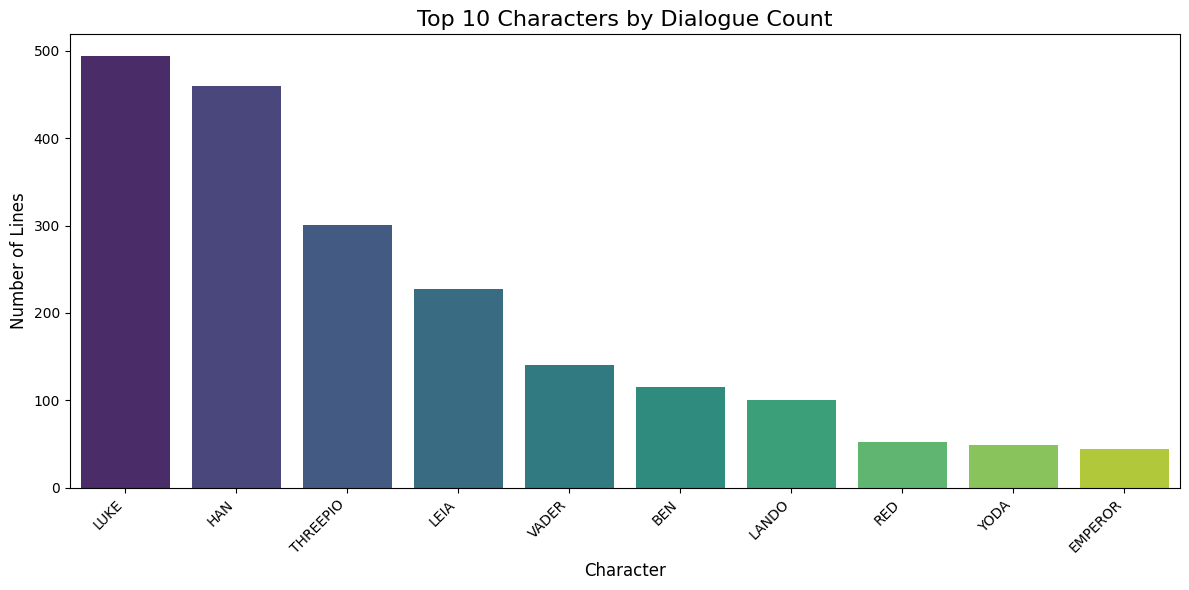


Top 10 Characters by Dialogue Count:
LUKE (Lines: 494)
HAN (Lines: 460)
THREEPIO (Lines: 301)
LEIA (Lines: 227)
VADER (Lines: 140)
BEN (Lines: 115)
LANDO (Lines: 101)
RED (Lines: 52)
YODA (Lines: 49)
EMPEROR (Lines: 44)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter: Filter the DataFrame to keep only the Top 10 characters with the most lines of dialogue.
# Store this in a new DataFrame called df_top10.
character_dialogue_counts = df['character'].value_counts()
df_top10 = character_dialogue_counts.head(10).reset_index()
df_top10.columns = ['character', 'line_count']

# Visualize: Use seaborn to create a Bar Plot of these top 10 characters and their line counts.
plt.figure(figsize=(12, 6))
sns.barplot(x='character', y='line_count', data=df_top10, palette='viridis')

# Set the title to 'Top 10 Characters by Dialogue Count'.
plt.title('Top 10 Characters by Dialogue Count', fontsize=16)

# Label the x-axis 'Character' and y-axis 'Number of Lines'.
plt.xlabel('Character', fontsize=12)
plt.ylabel('Number of Lines', fontsize=12)

# Rotate the x-axis labels 45 degrees so they are readable.
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Output: Print the names of the top 10 characters so we can verify them.
print("\nTop 10 Characters by Dialogue Count:")
for index, row in df_top10.iterrows():
    print(f"{row['character']} (Lines: {row['line_count']})")


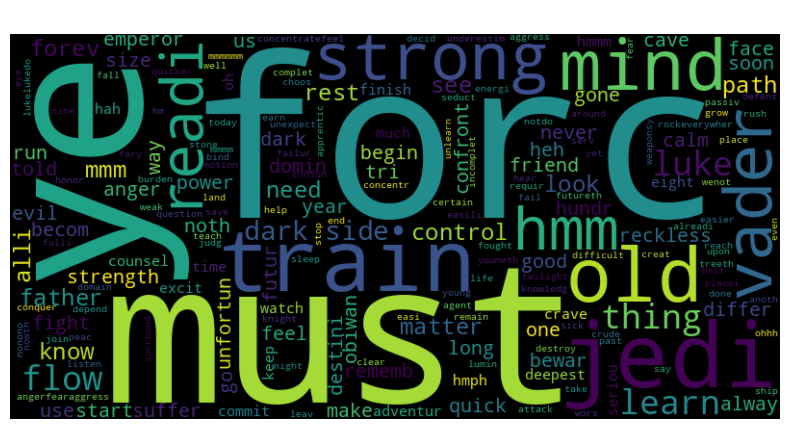

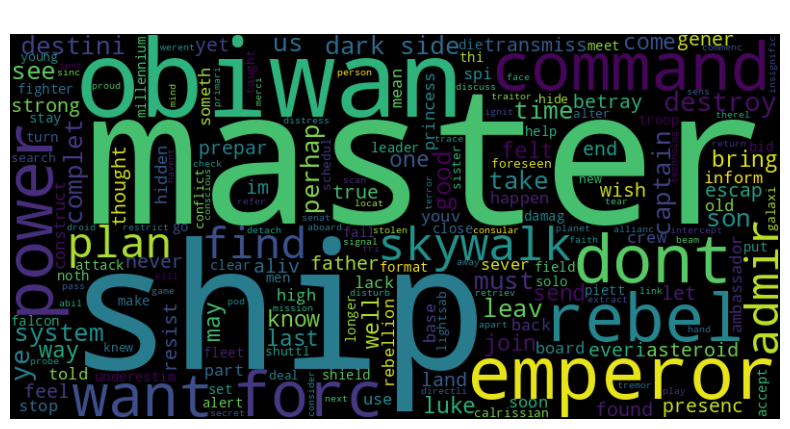

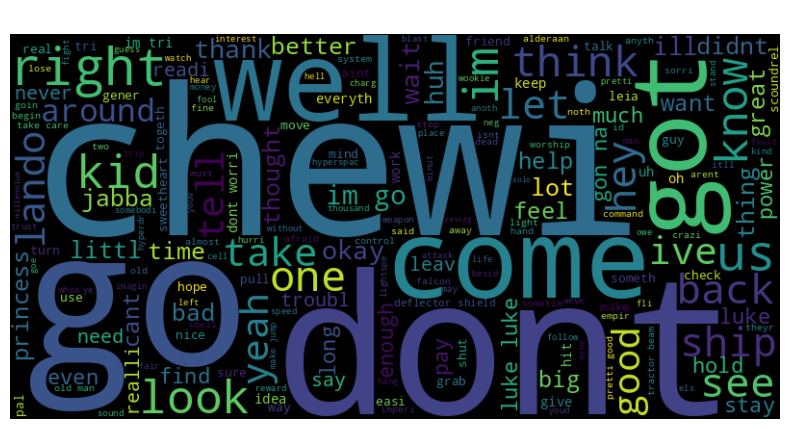

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(character_name):
    # Filter the original df for the specific character
    character_dialogue = df[df['character'] == character_name]['clean_dialogue']

    # Joins all their clean_dialogue into one long string
    all_words = ' '.join(character_dialogue.dropna().tolist())

    # Generate a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)

    # Displays the image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Sets the title
    plt.title(f'Word Cloud for {character_name}', color='white', fontsize=15)
    plt.show()

# Call the function for 'YODA', 'VADER', and 'HAN'
plot_wordcloud('YODA')
plot_wordcloud('VADER')
plot_wordcloud('HAN')


# Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare Data:
# Get the list of top 10 characters from df_top10
top_10_characters = df_top10['character'].tolist()

# Filter the original df to include only dialogues from the top 10 characters
df_filtered = df[df['character'].isin(top_10_characters)].copy()

# Ensure 'clean_dialogue' and 'character' columns exist and are not empty after filtering
if df_filtered.empty or 'clean_dialogue' not in df_filtered.columns or 'character' not in df_filtered.columns:
    print("Error: Filtered DataFrame is empty or missing required columns. Cannot proceed with model training.")
else:
    X = df_filtered['clean_dialogue']
    y = df_filtered['character']

    # Split: Split the data into training (80%) and testing (20%) sets using random_state=42.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize:
    # Initialize a TfidfVectorizer with max_features=2500.
    tfidf_vectorizer = TfidfVectorizer(max_features=2500)

    # Fit and transform X_train.
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)

    # Transform X_test.
    X_test_vec = tfidf_vectorizer.transform(X_test)

    # Train:
    # Initialize and train a LogisticRegression model (set max_iter=1000 to ensure it converges).
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, y_train)

    # Evaluate:
    # Predict on the test set
    y_pred = model.predict(X_test_vec)

    # Print the accuracy_score as a percentage.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy*100:.2f}%")


Model Accuracy: 37.53%


Complex Benchmarking (Confusion Matrix)


Classification Report:
              precision    recall  f1-score   support

         BEN       0.25      0.08      0.12        24
     EMPEROR       0.00      0.00      0.00         8
         HAN       0.41      0.53      0.46       108
       LANDO       1.00      0.08      0.15        24
        LEIA       0.23      0.07      0.10        45
        LUKE       0.30      0.62      0.40        92
         RED       1.00      0.36      0.53        11
    THREEPIO       0.61      0.40      0.49        47
       VADER       0.50      0.17      0.26        29
        YODA       0.00      0.00      0.00         9

    accuracy                           0.38       397
   macro avg       0.43      0.23      0.25       397
weighted avg       0.42      0.38      0.34       397



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


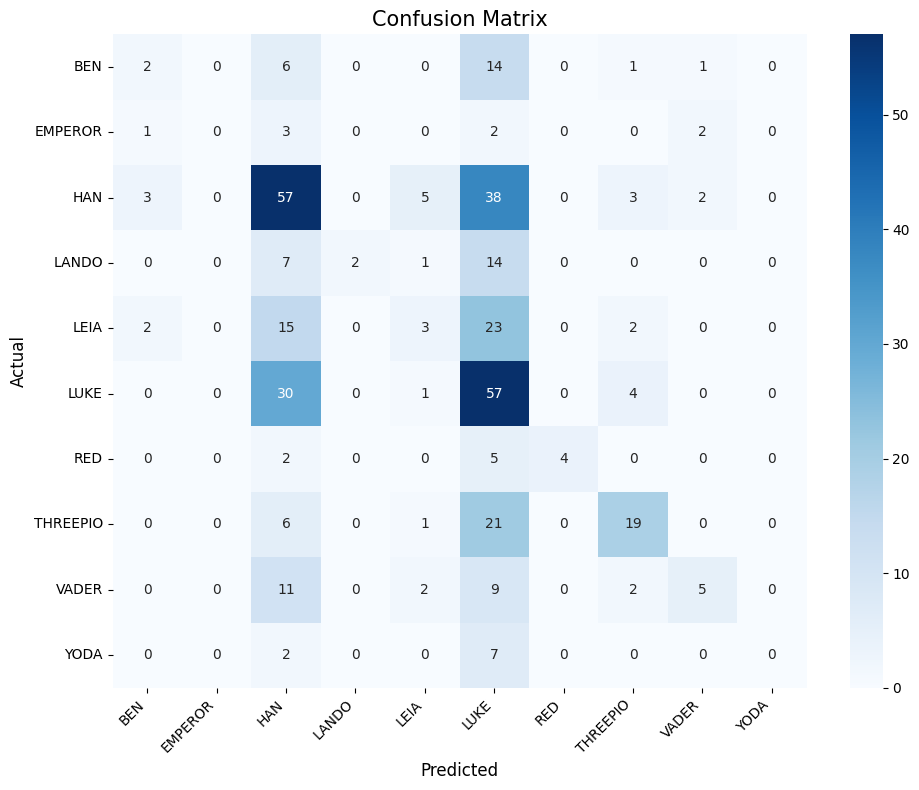

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for X_test (already done in the previous cell, but good practice to ensure)
# y_pred = model.predict(X_test_vec)

# Report: Print a full classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visual: Create a Confusion Matrix

# Compute the matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Use sns.heatmap to plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

# Label the x-axis 'Predicted' and y-axis 'Actual'
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Application (The Demo)

In [ ]:
def predict_character(text):
    # Clean the input text using the existing preprocess_text function
    cleaned_text = preprocess_text(text)

    # Vectorize the cleaned text using the already fitted tfidf_vectorizer
    # Reshape for single sample prediction if necessary, but tfidf_vectorizer handles a list of strings
    text_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict the character using the trained model
    predicted_character = model.predict(text_vectorized)[0]

    # Returns the character's name
    return predicted_character

# Create a list of 3 custom made-up Star Wars quotes
star_wars_quotes = [
    'I have a bad feeling about this',
    'Help me Obi-Wan',
    'The dark side is strong'
]

print("--- Star Wars Character Prediction Demo ---")
# Loop through them, print the quote, and print the predicted speaker.
for quote in star_wars_quotes:
    predicted_speaker = predict_character(quote)
    print(f"\nQuote: '{quote}'")
    print(f"Predicted Speaker: {predicted_speaker}")

# Add a print statement at the end
print("\n--- Demo Complete ---")


--- Star Wars Character Prediction Demo ---

Quote: 'I have a bad feeling about this'
Predicted Speaker: HAN

Quote: 'Help me Obi-Wan'
Predicted Speaker: VADER

Quote: 'The dark side is strong'
Predicted Speaker: VADER

--- Demo Complete ---
